In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

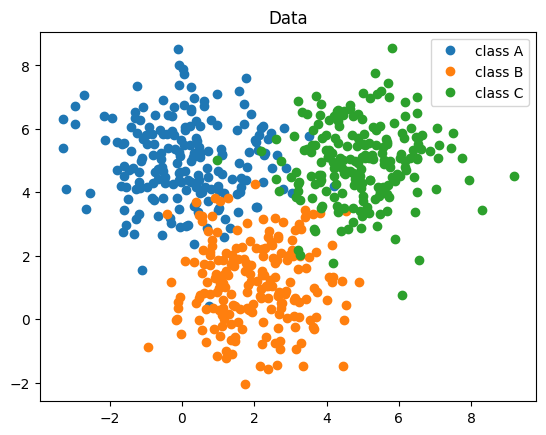

In [2]:
nperClust = 200
blur = 1.25
C = [5, 5]
A = [0, 5]
B = [2, 1]
clsA = [
    A[0] + np.random.randn(nperClust) * blur,
    A[1] + np.random.randn(nperClust) * blur,
]
clsB = [
    B[0] + np.random.randn(nperClust) * blur,
    B[1] + np.random.randn(nperClust) * blur,
]
clsC = [
    C[0] + np.random.randn(nperClust) * blur,
    C[1] + np.random.randn(nperClust) * blur,
]
label_np = np.vstack(
    (np.zeros((nperClust, 1)), np.ones((nperClust, 1)), np.full((nperClust, 1), 2))
)
data_np = np.hstack((clsA, clsB, clsC)).T
data = torch.tensor(data_np, dtype=torch.float)
labels = torch.tensor(label_np, dtype=torch.float)

# visualize data
plt.plot(clsA[0], clsA[1], "o", label="class A")
plt.plot(clsB[0], clsB[1], "o", label="class B")
plt.plot(clsC[0], clsC[1], "o", label="class C")
plt.legend()
plt.title("Data")
plt.show()

In [3]:
# organize data
label_np = np.hstack((np.zeros(nperClust), np.ones(nperClust), np.full(nperClust, 2)))
data_np = np.hstack((clsA, clsB, clsC)).T
data = torch.tensor(data_np, dtype=torch.float)
labels = torch.tensor(label_np, dtype=torch.long)

train_x, test_x, train_y, test_y = train_test_split(
    data, labels, test_size=0.2, random_state=42
)
train_data = TensorDataset(train_x, train_y)
test_data = TensorDataset(test_x, test_y)

train_data_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)
test_data_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=True)

print("Train data size: ", len(train_data))
print("No of batches: ", len(train_data_loader))
print("Batch size: ", train_data_loader.batch_size)
print("Test data size: ", len(test_data))

Train data size:  480
No of batches:  15
Batch size:  32
Test data size:  120


In [4]:
# ANN model
class ANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.input = nn.Linear(2, 8)
        self.hidden = nn.Linear(8, 8)
        self.output = nn.Linear(8, 3)

    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.hidden(x))
        x = self.output(x)
        return x

In [5]:
# test
model = ANN()
print(model(torch.randn(1, 2)))
print(model)

tensor([[ 0.0779,  0.0185, -0.7034]], grad_fn=<AddmmBackward0>)
ANN(
  (input): Linear(in_features=2, out_features=8, bias=True)
  (hidden): Linear(in_features=8, out_features=8, bias=True)
  (output): Linear(in_features=8, out_features=3, bias=True)
)


In [7]:
# create model
def create_model(optName):
    model = ANN()
    optifun = getattr( torch.optim,optName )
    optimizer = optifun(model.parameters(),lr=.01)
    loss = nn.CrossEntropyLoss()
    return model, optimizer, loss


# test
model, optimizer, loss = create_model('SGD')
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [8]:
# train
def train(model, optimizer, loss, train_data_loader, test_data_loader, epochs=100):
    train_acc = []
    test_acc = []
    for epoch in range(epochs):
        model.train()
        batch_acc = []
        for x, y in train_data_loader:
            y_hat = model(x)
            loss_value = loss(y_hat, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            batch_acc.append(
                torch.mean((torch.argmax(y_hat, dim=1) == y).float()) * 100
            )

        train_acc.append(torch.mean(torch.tensor(batch_acc)))
        model.eval()
        with torch.no_grad():
            x, y = next(iter(test_data_loader))
            y_hat = model(x)
            test_acc.append(torch.mean((torch.argmax(y_hat, dim=1) == y).float()) * 100)

    return train_acc, test_acc

In [10]:
# expiriment
optums = ["SGD", "Adam", "RMSprop"]
epochs = 50
train_acc = np.zeros((len(optums), epochs))
test_acc = np.zeros((len(optums), epochs))

for i, optim in enumerate(optums):
    model, optimizer, loss = create_model(optim)
    train_acc[i], test_acc[i] = train(
        model, optimizer, loss, train_data_loader, test_data_loader, epochs
    )
    print(
        "optimizer: ",
        optim,
        "Train accuracy: ",
        train_acc[i][-1],
        "Test accuracy: ",
        test_acc[i][-1],
    )

optimizer:  SGD Train accuracy:  89.375 Test accuracy:  94.16666412353516
optimizer:  Adam Train accuracy:  93.125 Test accuracy:  93.33333587646484
optimizer:  RMSprop Train accuracy:  92.91666412353516 Test accuracy:  94.16666412353516


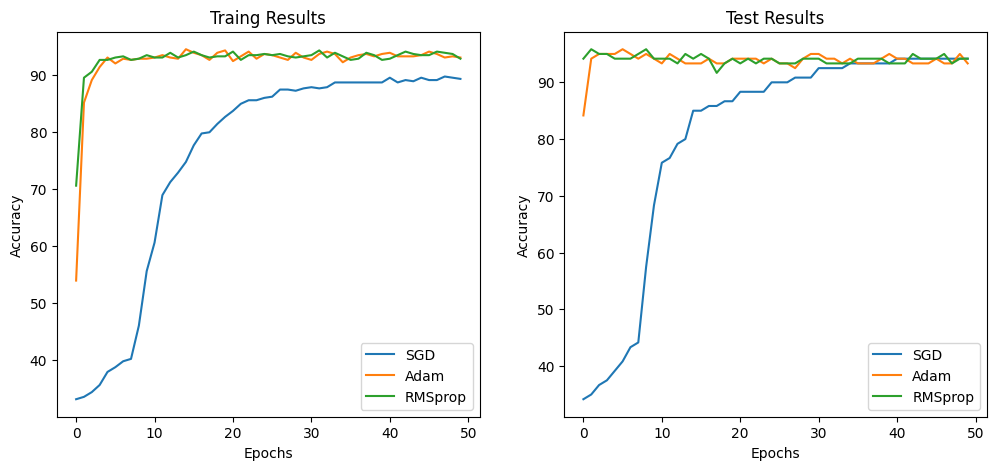

In [11]:
# plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for i, optim in enumerate(optums):
    plt.plot(train_acc[i], label=optim)
plt.legend()
plt.title("Traing Results")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
for i, optim in enumerate(optums):
    plt.plot(test_acc[i], label=optim)
plt.legend()
plt.title("Test Results")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()